# Imports

In [1]:
from scipy.spatial.distance import squareform
from numpy import pi as PI
from scipy.integrate import quad
from collections import Counter
from scipy.special import iv
from functools import partial


import time
import scipy
import numpy as np
import seaborn as sns
import ringity as rng
import networkx as nx
import matplotlib.pyplot as plt

sns.set()
rng.set()
%matplotlib inline

### Decorator

In [2]:
def support(f, left_limit, right_limit):
    """This function can be used as a decorater 
    to restrict the support of its input function."""
    def f_rest(x, *args, **kwargs):
        return np.where(left_limit <= x <= right_limit, f(x, *args, **kwargs), 0)
    return f_rest

### Conditional distributions

In [3]:
@partial(np.vectorize, excluded={'theta', 'kappa'})
@partial(support, left_limit=0, right_limit=PI)
def cond_Delta(x, theta, kappa):
    return (np.exp(kappa*np.cos(theta+x)) + np.exp(kappa*np.cos(theta-x)))/(2*PI*iv(0,kappa))

@partial(np.vectorize, excluded={'theta', 'kappa'})
@partial(support, left_limit=0, right_limit=PI)
def Cond_Delta(x, theta, kappa):
    return scipy.integrate.quad(lambda t : np.exp(kappa*np.cos(theta-t))/(2*PI*iv(0,kappa)), -x, x)[0]


@partial(np.vectorize, excluded={'theta', 'kappa', 'a'})
@partial(support, left_limit=0, right_limit=1)
def cond_s(t, theta, kappa, a):
    return 2*a*PI*cond_Delta(2*a*PI*(1-t), theta=theta, kappa=kappa)

@partial(np.vectorize, excluded={'theta', 'kappa', 'a'})
@partial(support, left_limit=0, right_limit=np.inf)
def Cond_s(t, theta, kappa, a):
    return np.where(2-1/a < t, 1 - Cond_Delta(2*a*PI*(1-t), theta=theta, kappa=kappa), 0)


@partial(np.vectorize, excluded={'theta', 'kappa', 'a', 'A', 'B'})
@partial(support, left_limit=0, right_limit=1)
def cond_P(t, theta, mu, eta):
    alpha, beta = rng.mueta_to_alphabeta(mu,eta)
    ppf = scipy.stats.beta.ppf(t, a=alpha, b=beta)
    return cond_s(ppf, theta=theta, kappa=kappa, a=a)/scipy.stats.beta.pdf(ppf, a=alpha, b=beta)

@partial(np.vectorize, excluded={'theta', 'kappa', 'a', 'A', 'B'})
@partial(support, left_limit=0, right_limit=np.inf)
def Cond_P(t, theta, mu, eta):
    alpha, beta = rng.mueta_to_alphabeta(mu,eta)
    ppf = scipy.stats.beta.ppf(t, a=alpha, b=beta)
    return Cond_s(ppf, theta=theta, kappa=kappa, a=a)

In [4]:
def cond_Delta(x, theta, kappa):
    return np.where(x<=0, 0,
                    np.where(x>=PI, 0,
                             (np.exp(kappa*np.cos(theta+x)) + np.exp(kappa*np.cos(theta-x)))/(2*PI*iv(0,kappa))))

def cond_s(t, theta, kappa, a):
    return np.where(t<=0, 0,
                    np.where(t>=1, 0,
                             2*a*PI*cond_Delta(2*a*PI*(1-t), theta=theta, kappa=kappa)))

### Degree distribution

In [5]:
def rho_dot(theta, mu, eta):
    alpha, beta = rng.mueta_to_alphabeta(mu=mu, eta=eta)
    def integral(x):
        return a/rng.bessel_I0(kappa) * quad(lambda t : scipy.stats.beta.cdf(t, a=alpha, b=beta) *
                                                     (np.exp(kappa*np.cos(x+2*a*PI*(1-t))) + 
                                                      np.exp(kappa*np.cos(x-2*a*PI*(1-t)))),
                                          0, 1)[0]
    return np.vectorize(integral)(theta)

def deg_distribution(N, kappa, mu, eta, size=2**7):
    thetas = np.random.vonmises(mu=0, kappa=kappa, size=size)
    p_count = rho_dot(thetas, mu=mu, eta=eta)
    return {i:np.mean(scipy.stats.binom.pmf(i, n=N-1, p=p_count)) for i in range(N)}

# Realisations

In [6]:
sample_size = 2**4

default = 0.05

N   = 2**10
rho = 0.05

eta   = 1.
kappa = 0
a     = 0.125

positions_list = []
NDM_list = []
NSM_list = []
NPM_list = []

deg_list   = []

t1 = time.time()

for i in range(sample_size):
    positions, NDM, NSM, NPM = rng.network_model_samples(N = N, 
                                                                 rho = rho, 
                                                                 eta = eta, 
                                                                 kappa = kappa, 
                                                                 a = a)
    
    positions_list.append(positions)
    NDM_list.append(NDM)
    NSM_list.append(NSM)
    NPM_list.append(NPM)
    
    R = squareform(np.random.uniform(size=round(N*(N-1)/2)))
    A = np.where(NPM>R, 1, 0)
    G = nx.from_numpy_array(A)
    deg_list += [deg for _,deg in G.degree]

t2 = time.time()
print(f'time: {t2-t1}sek')

time: 5.36817479133606sek


In [7]:
pos = {node: (np.cos(positions[node]), np.sin(positions[node])) for node in G.nodes()}

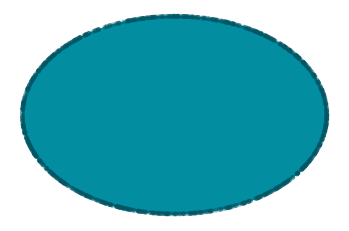

In [8]:
nx_fig = plt.figure()
ax = nx_fig.gca()
rng.plot_nx(G, pos=pos, ax=ax)

# Degree distribution

In [9]:
# This one takes a while (2-3 min)

sim_size = 2**11
t1 = time.time()
mu = rng.get_mu(rho=rho, eta=eta, a=a, kappa=kappa)
deg_dict = deg_distribution(N=N, kappa=kappa, mu=mu, eta=eta, size=sim_size)
t2 = time.time()
print(t2-t1)

/Users/markusyoussef/Desktop/git/supplements/venv/ringity/lib/python3.7/site-packages/ipykernel_launcher.py:7: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  import sys


KeyboardInterrupt: 

In [10]:
degCount_obs = Counter(sorted(deg_list))
degs_obs, cnts_obs = zip(*degCount_obs.items())
cnts_obs = np.array(cnts_obs)/sample_size

In [11]:
cnts_exp = [deg_dict[deg]*N for deg in degs_obs]

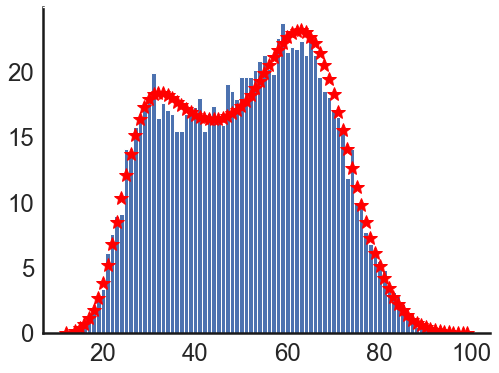

In [12]:
width = 1

deg_fig, ax = plt.subplots(figsize=(8,6))
deg_fig.patch.set_alpha(0)

ax.bar(np.array(degs_obs), cnts_obs, width=width, color='b');
ax.plot(np.array(degs_obs), cnts_exp, '*', markersize=15, color='red');

rng.ax_setup(ax)

# Testing unconditional distributions

### Distribution of the distance $D$

In [10]:
bins = 51

weights = np.sort(np.concatenate([squareform(NDM) for NDM in NDM_list]))
freq, delta = np.histogram(weights, bins=bins)
delta  = np.array([(a+b)/2 for a,b in zip(delta[:-1],delta[1:])])

width = delta[1]-delta[0]

freq = np.array(freq)
freq = freq/(np.sum(freq)*(width))

x = np.linspace(0, PI, 101)

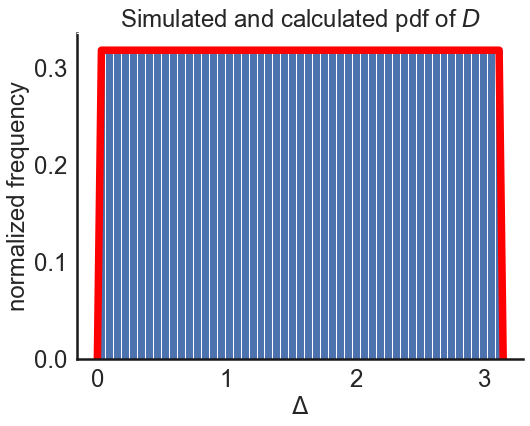

In [11]:
delta_pdf_fig, ax = plt.subplots(figsize=(8,6))
delta_pdf_fig.patch.set_alpha(0)

ax.bar(delta, freq, width=width, color='b', log=False);
ax.plot(x, rng.pdf_distance(x, kappa=kappa), color='red', linewidth=7.5);

ax.set_xlabel(r'$\Delta$', fontsize=24)
ax.set_ylabel('normalized frequency', fontsize=24)
ax.set_title(r'Simulated and calculated pdf of $D$', fontsize=24);

rng.ax_setup(ax)

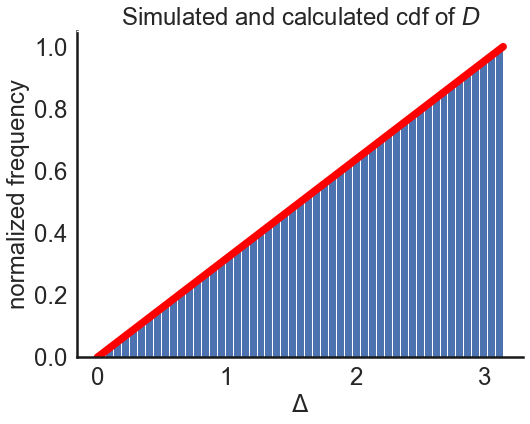

In [12]:
delta_cdf_fig, ax = plt.subplots(figsize=(8,6))
delta_cdf_fig.patch.set_alpha(0)

cumfreq = (width)*np.cumsum(freq)

ax.bar(delta, cumfreq, width=width, color='b');
ax.plot(x, rng.cdf_distance(x,kappa), color='red', linewidth=7.5);

ax.set_xlabel(r'$\Delta$', fontsize=24)
ax.set_ylabel('normalized frequency', fontsize=24)
ax.set_title(r'Simulated and calculated cdf of $D$', fontsize=24);

rng.ax_setup(ax)

### Distribution of the similarity $S$

In [13]:
bins = 51

weights = np.sort(np.concatenate([squareform(NSM) for NSM in NSM_list]))
freq, s = np.histogram(weights, bins=bins, range=(0,1))
s  = np.array([(a+b)/2 for a,b in zip(s[:-1],s[1:])])

width = s[1]-s[0]

freq = np.array(freq)
freq = freq/(np.sum(freq)*(width))

x = np.linspace(0,1, 101)

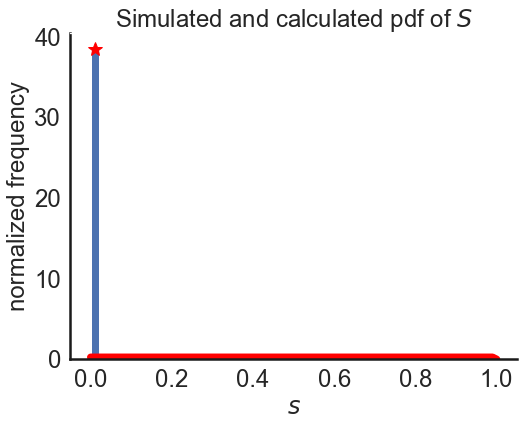

In [14]:
s_pdf_fig, ax = plt.subplots(figsize=(8,6))
s_pdf_fig.patch.set_alpha(0)

ax.bar(s, freq, width=width, color='b', log=False);
ax.plot(x, rng.pdf_similarity(x, kappa=kappa, a=a), color='red', linewidth=7.5);
ax.plot(max(2-1/a,0)+width/2, freq[0], '*', color='red', markersize=15);

ax.set_xlabel(r'$s$', fontsize=24)
ax.set_ylabel('normalized frequency', fontsize=24)
ax.set_title(r'Simulated and calculated pdf of $S$', fontsize=24);

rng.ax_setup(ax)

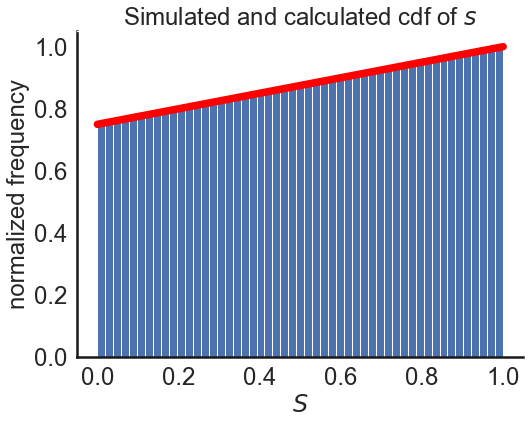

In [15]:
s_cdf_fig, ax = plt.subplots(figsize=(8,6))
s_cdf_fig.patch.set_alpha(0)

cumfreq = (width)*np.cumsum(freq)

ax.bar(s, cumfreq, width=width, color='b');
ax.plot(x, rng.cdf_similarity(x,kappa=kappa, a=a), color='red', linewidth=7.5);

ax.set_xlabel(r'$S$', fontsize=24)
ax.set_ylabel('normalized frequency', fontsize=24)
ax.set_title(r'Simulated and calculated cdf of $s$', fontsize=24);

rng.ax_setup(ax)

### Distribution of the interaction probability $P$

In [16]:
bins = 51

weights = np.sort(np.concatenate([squareform(NPM) for NPM in NPM_list]))
freq, P = np.histogram(weights, bins=bins, range=(0,1))
P  = np.array([(a+b)/2 for a,b in zip(P[:-1],P[1:])])

width = P[1]-P[0]

freq = np.array(freq)
freq = freq/(np.sum(freq)*(width))

x = np.linspace(0,1, 501)

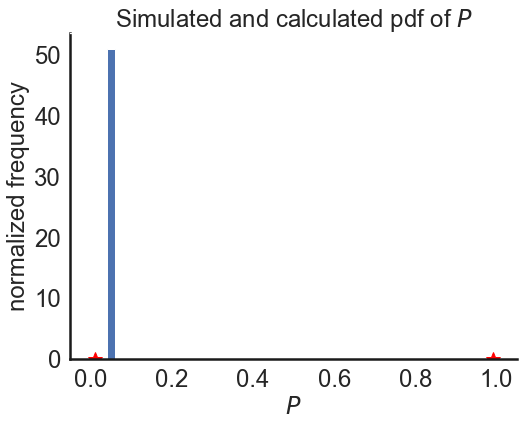

In [17]:
P_pdf_fig, ax = plt.subplots(figsize=(8,6))
P_pdf_fig.patch.set_alpha(0)

ax.bar(P, freq, width=width, color='b', log=False);
ax.plot(x, rng.pdf_connection_probability(x, rho, eta, a, kappa), color='red', linewidth=7.5);
ax.plot(  width/2, freq[0] , '*', color='red', markersize=15);
ax.plot(1-width/2, freq[-1], '*', color='red', markersize=15);

ax.set_xlabel(r'$P$', fontsize=24)
ax.set_ylabel('normalized frequency', fontsize=24)
ax.set_title(r'Simulated and calculated pdf of $P$', fontsize=24);

rng.ax_setup(ax)

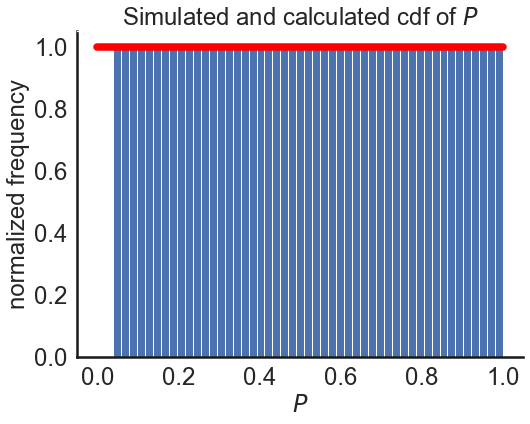

In [18]:
P_cdf_fig, ax = plt.subplots(figsize=(8,6))
P_cdf_fig.patch.set_alpha(0)

cumfreq = (width)*np.cumsum(freq)

ax.bar(P, cumfreq, width=width, color='b');
ax.plot(x, rng.cdf_connection_probability(x, rho, eta, a, kappa), color='red', linewidth=7.5);

ax.set_xlabel(r'$P$', fontsize=24)
ax.set_ylabel('normalized frequency', fontsize=24)
ax.set_title(r'Simulated and calculated cdf of $P$', fontsize=24);

rng.ax_setup(ax)

# Testing conditional distributions

### Choosing a node

In [22]:
n = np.random.randint(N)
theta = positions[n]

### Distribution of the conditional distance $D_{\vartheta}$

In [23]:
bins = 51

weights = np.sort(NDM[n,:])
freq, delta = np.histogram(weights, bins=bins)
delta  = np.array([(a+b)/2 for a,b in zip(delta[:-1],delta[1:])])

width = delta[1]-delta[0]

freq = np.array(freq)
freq = freq/(np.sum(freq)*(width))

x = np.linspace(0, PI, 101)

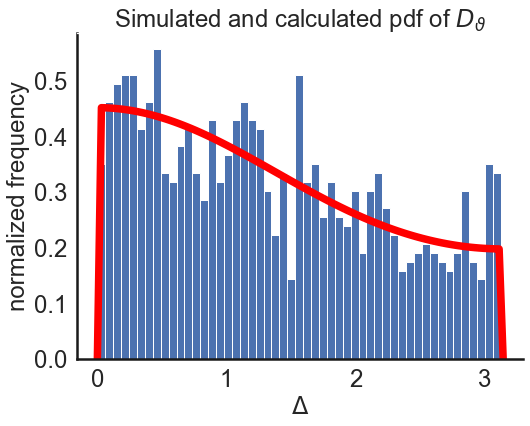

In [24]:
pdf_fig, ax = plt.subplots(figsize=(8,6))
pdf_fig.patch.set_alpha(0)

ax.bar(delta, freq, width=width, color='b');
ax.plot(x, cond_Delta(x, theta=theta, kappa=kappa), color='red', linewidth=7.5);

ax.set_xlabel(r'$\Delta$', fontsize=24)
ax.set_ylabel('normalized frequency', fontsize=24)
ax.set_title(r'Simulated and calculated pdf of $D_{\vartheta}}$', fontsize=24);

rng.ax_setup(ax)

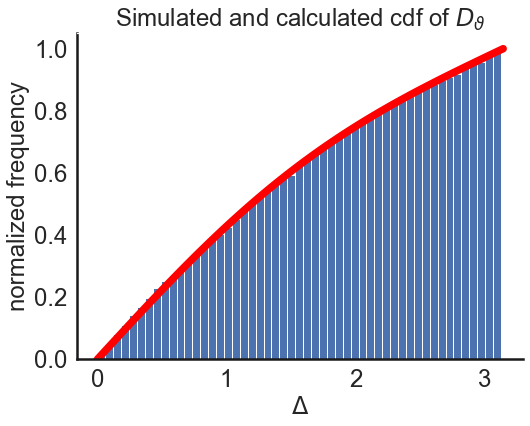

In [25]:
cdf_fig, ax = plt.subplots(figsize=(8,6))
cdf_fig.patch.set_alpha(0)

cumfreq = (width)*np.cumsum(freq)

ax.bar(delta, cumfreq, width=width, color='b');
ax.plot(x, Cond_Delta(x, theta=theta, kappa=kappa), color='red', linewidth=7.5);

ax.set_xlabel(r'$\Delta$', fontsize=24)
ax.set_ylabel('normalized frequency', fontsize=24)
ax.set_title(r'Simulated and calculated cdf of $D_{\vartheta}}$', fontsize=24);

rng.ax_setup(ax)

### Distribution of the conditional similarity $S_{\vartheta}$

In [26]:
bins = 51

weights = np.sort(NSM[n,:])
freq, s = np.histogram(weights, bins=bins)
s  = np.array([(a+b)/2 for a,b in zip(s[:-1],s[1:])])

width = s[1]-s[0]

freq = np.array(freq)
freq = freq/(np.sum(freq)*(width))

x = np.linspace(0,1, 101)

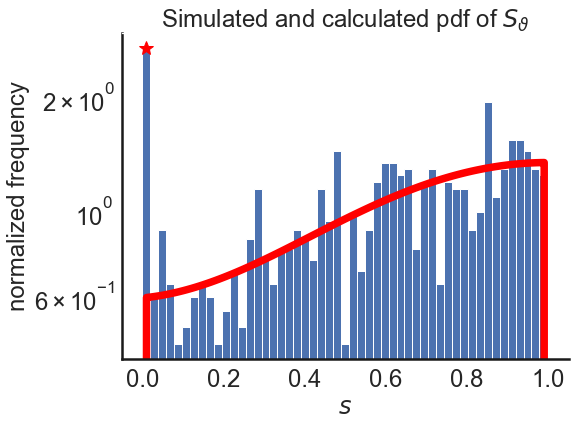

In [27]:
pdf_fig, ax = plt.subplots(figsize=(8,6))
pdf_fig.patch.set_alpha(0)

ax.bar(s, freq, width=width, color='b', log=True);
ax.plot(x, cond_s(x, theta=theta, kappa=kappa, a=a), color='red', linewidth=7.5);
ax.plot(s[0], freq[0] , '*', color='red', markersize=15);

ax.set_xlabel(r'$s$', fontsize=24)
ax.set_ylabel('normalized frequency', fontsize=24)
ax.set_title(r'Simulated and calculated pdf of $S_{\vartheta}$', fontsize=24);

rng.ax_setup(ax)

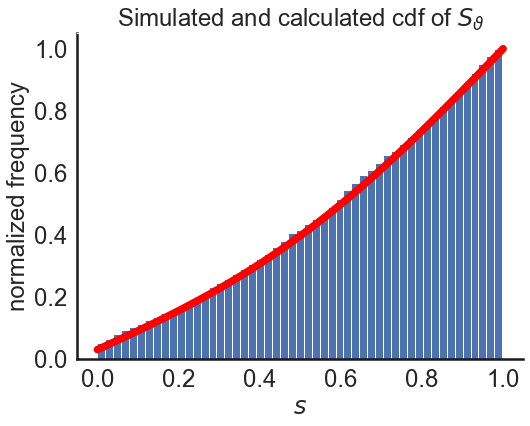

In [28]:
cdf_fig, ax = plt.subplots(figsize=(8,6))
cdf_fig.patch.set_alpha(0)

cumfreq = (width)*np.cumsum(freq)

ax.bar(s, cumfreq, width=width, color='b');
ax.plot(x, Cond_s(x, theta=theta, kappa=kappa, a=a), color='red', linewidth=7.5);

ax.set_xlabel(r'$s$', fontsize=24)
ax.set_ylabel('normalized frequency', fontsize=24)
ax.set_title(r'Simulated and calculated cdf of $S_{\vartheta}}$', fontsize=24);

rng.ax_setup(ax)

### Distribution of the conditional interaction probability $P_{\vartheta}$

In [29]:
mu = rng.get_mu(rho=rho, eta=eta, a=a, kappa=kappa)

In [30]:
bins = 51

weights = np.sort(NPM[n,:])
freq, P = np.histogram(weights, bins=bins, range=(0,1))
P  = np.array([(a+b)/2 for a,b in zip(P[:-1],P[1:])])

width = P[1]-P[0]

freq = np.array(freq)
freq = freq/(np.sum(freq)*width)

/Users/markusyoussef/Desktop/git/supplements/venv/ringity/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


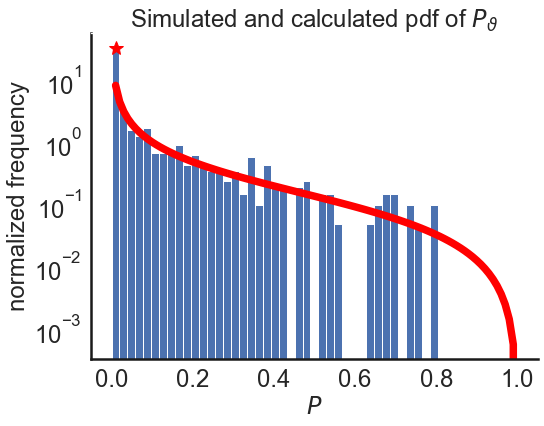

In [31]:
pdf_fig, ax = plt.subplots(figsize=(8,6))
pdf_fig.patch.set_alpha(0)

ax.bar(P, freq, width=width, color='b', log=True);
ax.plot(x, cond_P(x, theta=theta, mu=mu, eta=eta), color='red', linewidth=7.5);
ax.plot(P[0], freq[0] , '*', color='red', markersize=15);
ax.plot(P[-1], freq[-1] , '*', color='red', markersize=15);

ax.set_xlabel(r'$P$', fontsize=24)
ax.set_ylabel('normalized frequency', fontsize=24)
ax.set_title(r'Simulated and calculated pdf of $P_{\vartheta}}$', fontsize=24);

rng.ax_setup(ax)

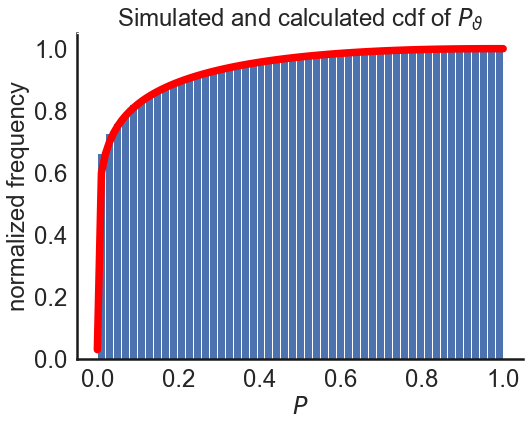

In [32]:
cdf_fig, ax = plt.subplots(figsize=(8,6))
cdf_fig.patch.set_alpha(0)

cumfreq = width*np.cumsum(freq)

ax.bar(P, cumfreq, width=width, color='b');
ax.plot(x, Cond_P(x, theta=theta, mu=mu, eta=eta), color='red', linewidth=7.5);


ax.set_xlabel(r'$P$', fontsize=24)
ax.set_ylabel('normalized frequency', fontsize=24)
ax.set_title(r'Simulated and calculated cdf of $P_{\vartheta}}$', fontsize=24);

rng.ax_setup(ax)